In [8]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [9]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [10]:
!unzip -uq "/content/ResizeDataset.zip" -d "/content"

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [2]:
train_dir='C:\\android studio\\Android-App-Skin-Cancer-Detector\\Android-App-Skin-Cancer-Detector\\Training\\Dataset'

In [3]:
Labels = ['Benign', 'Malignant']

In [4]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Benign
1 Malignant


In [5]:
print('Number of classes:',len(Labels))

Number of classes: 2


In [6]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [7]:
IMAGE_SIZE

(224, 224)

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 5788 images belonging to 2 classes.
Found 3858 images belonging to 2 classes.


In [9]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [10]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [11]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
___________________

In [12]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [13]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
361/361 [==============================] - 289s 791ms/step - loss: 0.3864 - accuracy: 0.8352 - val_loss: 0.2573 - val_accuracy: 0.8921
Epoch 2/15
361/361 [==============================] - 240s 664ms/step - loss: 0.3086 - accuracy: 0.8702 - val_loss: 0.2559 - val_accuracy: 0.8968
Epoch 3/15
361/361 [==============================] - 242s 671ms/step - loss: 0.2918 - accuracy: 0.8796 - val_loss: 0.2621 - val_accuracy: 0.8970
Epoch 4/15
361/361 [==============================] - 254s 705ms/step - loss: 0.2769 - accuracy: 0.8812 - val_loss: 0.2511 - val_accuracy: 0.8970
Epoch 5/15
361/361 [==============================] - 245s 680ms/step - loss: 0.2730 - accuracy: 0.8799 - val_loss: 0.2385 - val_accuracy: 0.9098
Epoch 6/15
361/361 [==============================] - 237s 657ms/step - loss: 0.2650 - accuracy: 0.8870 - val_loss: 0.2371 - val_accuracy: 0.9033
Epoch 7/15
361/361 [==============================] - 237s 658ms/step - loss: 0.2471 - accuracy: 0.8962 - val_loss: 0.2406 -

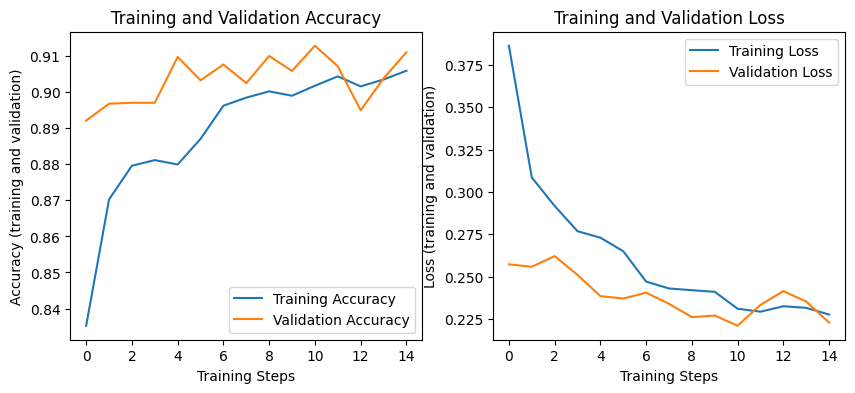

In [15]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 1s 542ms/step
class: Benign, confidence: 0.569643


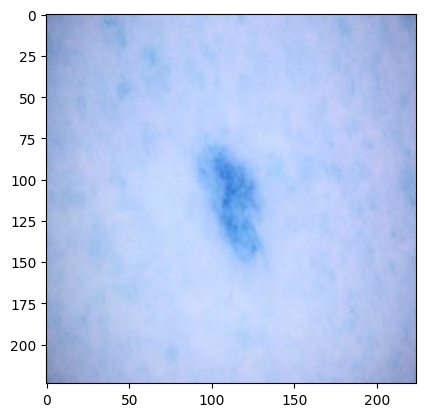

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 65ms/step
class: Benign, confidence: 0.973996


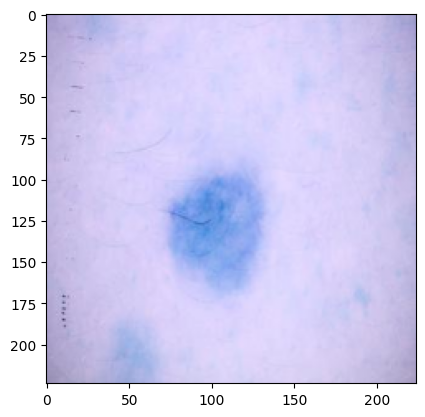

1/1 [==============================] - 0s 48ms/step
class: Benign, confidence: 0.972429


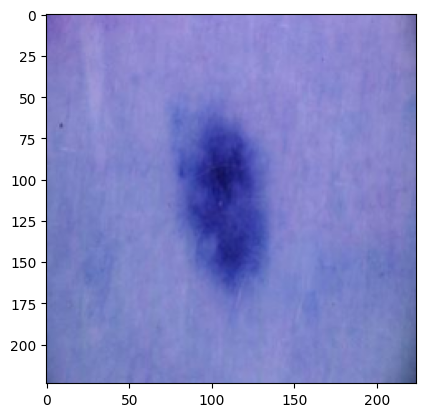

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 57ms/step
class: Benign, confidence: 0.871882


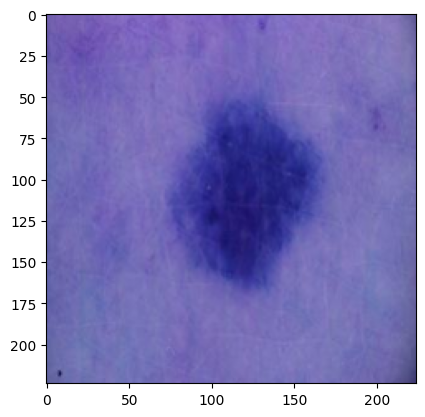

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 54ms/step
class: Benign, confidence: 0.976624


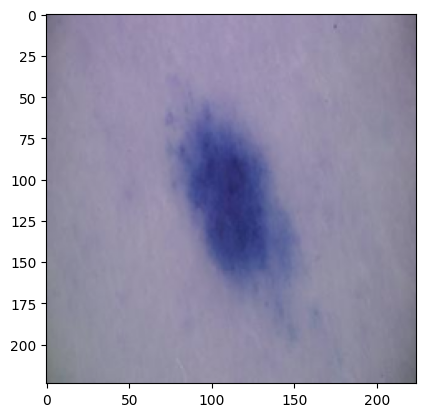

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 52ms/step
class: Benign, confidence: 0.692944


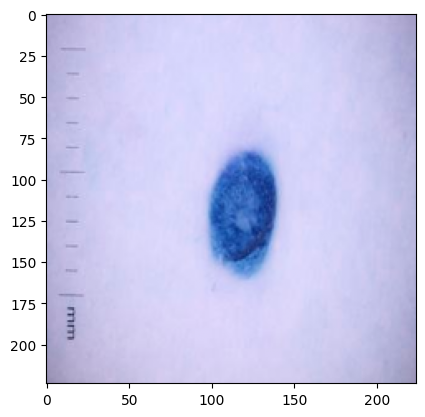

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 53ms/step
class: Malignant, confidence: 0.904905


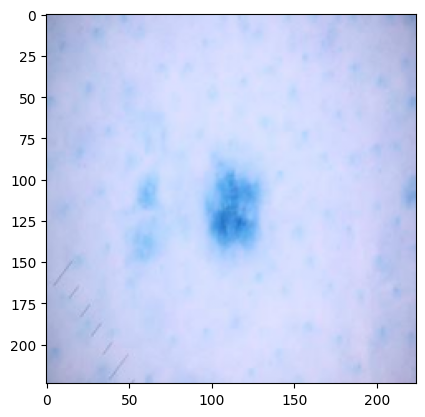

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 57ms/step
class: Benign, confidence: 0.895087


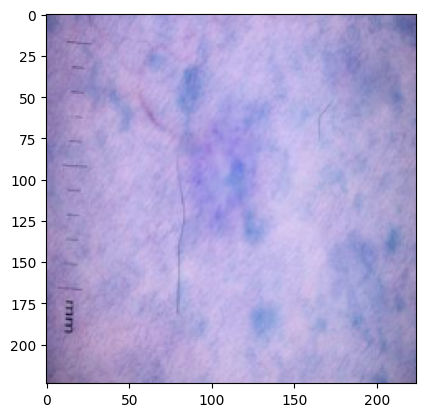

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 60ms/step
class: Benign, confidence: 0.960341


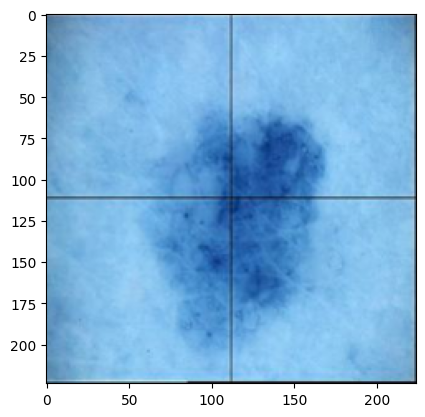

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 108ms/step
class: Benign, confidence: 0.948116


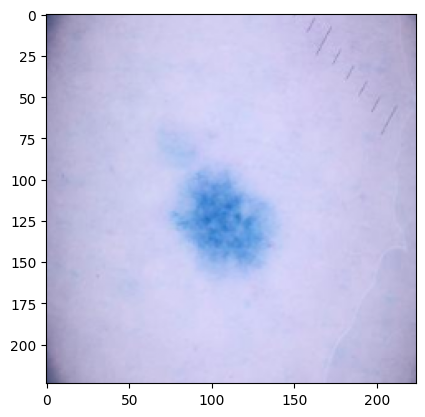

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 49ms/step
class: Malignant, confidence: 0.974687


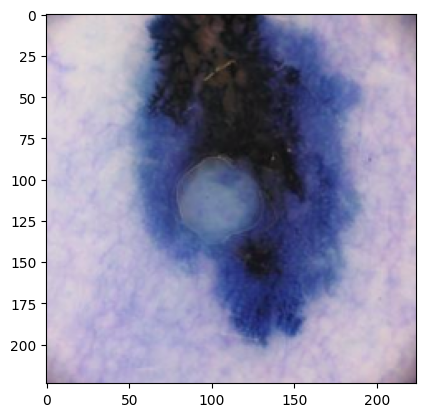

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 50ms/step
class: Benign, confidence: 0.845918


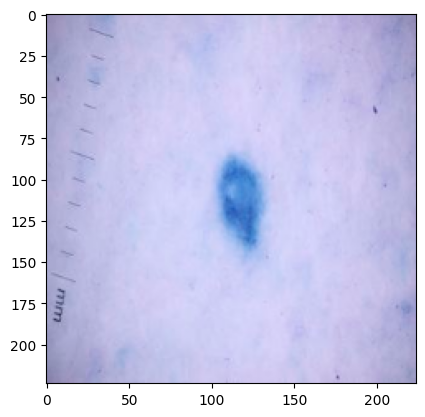

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 53ms/step
class: Benign, confidence: 0.879209


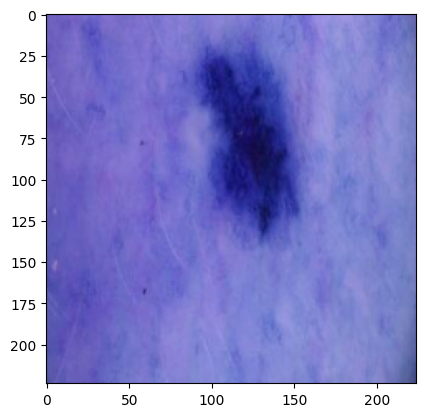

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 60ms/step
class: Benign, confidence: 0.792384


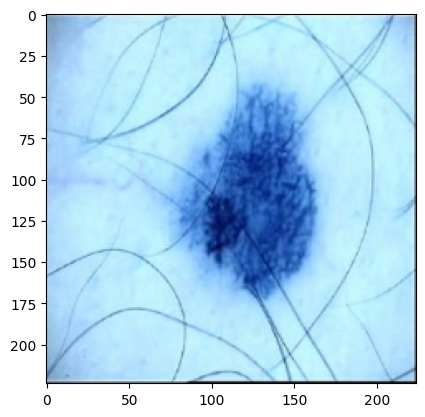

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 87ms/step
class: Benign, confidence: 0.936592


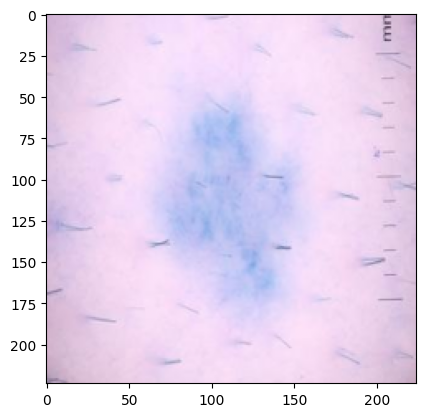

<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 52ms/step
class: Benign, confidence: 0.765508


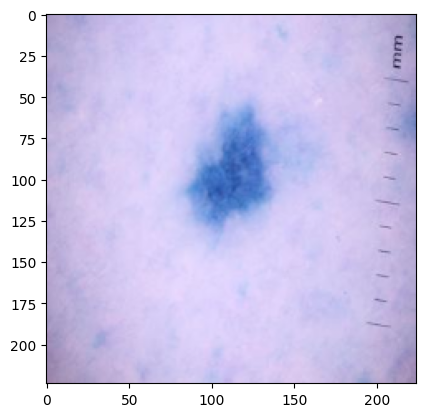

<Figure size 640x480 with 0 Axes>

In [17]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    
    
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

242/242 [==============================] - 92s 376ms/step
Classification Report
              precision    recall  f1-score   support

      benign       0.91      0.93      0.92      2008
   malignant       0.92      0.90      0.91      1850

    accuracy                           0.91      3858
   macro avg       0.91      0.91      0.91      3858
weighted avg       0.91      0.91      0.91      3858

242/242 [==============================] - 90s 371ms/step - loss: 0.2265 - accuracy: 0.9132
[0.2264585942029953, 0.913167417049408]


Confusion Matrix


<Axes: >

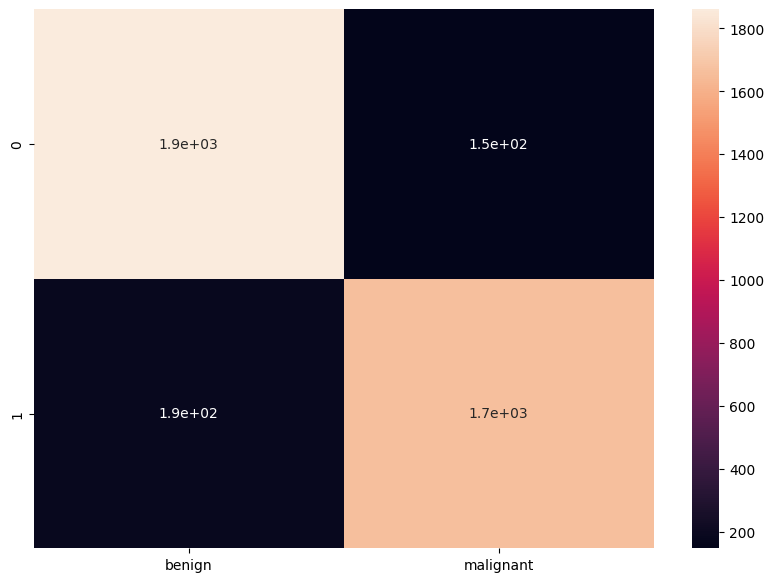

In [22]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [23]:
cd C:\android studio\Android-App-Skin-Cancer-Detector\Android-App-Skin-Cancer-Detector

C:\android studio\Android-App-Skin-Cancer-Detector\Android-App-Skin-Cancer-Detector


#Export as saved model and convert to TFLite

In [24]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1686203579\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1686203579\assets


'/tmp/saved_models/1686203579'

In [25]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [26]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: malignant, file: malignant\melanoma_6313.jpg
1/1 [==============================] - 1s 521ms/step
PREDICTED: class: Malignant, confidence: 1.000000


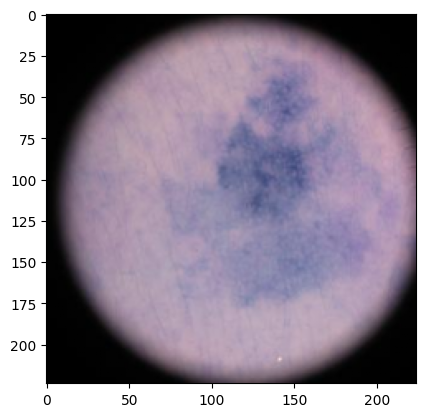

<Figure size 640x480 with 0 Axes>

SOURCE: class: benign, file: benign\melanoma_1788.jpg
1/1 [==============================] - 0s 65ms/step
PREDICTED: class: Benign, confidence: 0.717148


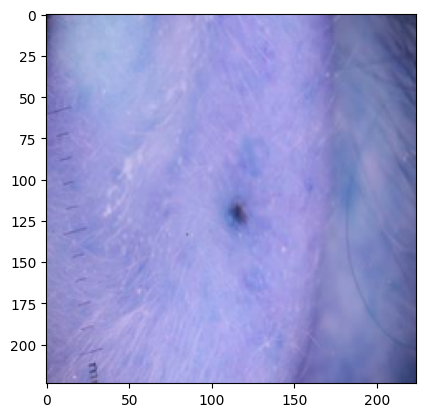

In [27]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [28]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11542820